# **Parameter Optimisation for GITT** 

This notebook is created to provide an example for ```GITT``` optimisation problem. Diffisuion Coefficient is optimised in this notebook. Only voltage will be considered for optimisation in this example.
 The workflow is as follows:


In [1]:
#%pip install git+https://github.com/paramm-team/pybamm-param.git -q
import pybamm
import pbparam
import pandas as pd

We are creating a syntethic data first.

In [2]:
syn_model = pybamm.lithium_ion.SPM()

Synthethic data parameters are defined here:

In [3]:
syn_param = pybamm.ParameterValues("Chen2020")

# Use a linearised OCP to check model is working
def linear_OCP(sto):
    return 4.2935 - 1.1352 * (sto - 0.2661)

syn_param.update(
            {
                "Positive electrode OCP [V]": linear_OCP,
                "Positive electrode diffusivity [m2.s-1]": 1e-15,
            },
            check_already_exists=True,
)

syn_sim = pybamm.Simulation(syn_model, parameter_values=syn_param)
syn_solution = syn_sim.solve([0, 100])

Then, it is plotted:

In [4]:
syn_solution.plot(['Voltage [V]'])

interactive(children=(FloatSlider(value=0.0, description='t', step=1.0), Output()), _dom_classes=('widget-inte…

The synthethic data is passed to a dataframe:

In [5]:
d = {'Time [s]':syn_solution["Time [s]"].entries, 'Voltage [V]': syn_solution["Voltage [V]"].entries}

data = pd.DataFrame(data = d)

In [6]:
data

,Time [s],Voltage [V]
0,0.000000,4.079514
1,1.010101,4.078092
2,2.020202,4.076567
3,3.030303,4.075002
4,4.040404,4.073431
...,...,...
95,95.959596,3.984052
96,96.969697,3.983393
97,97.979798,3.982737
98,98.989899,3.982085


PbParam model to be used for GITT needs to be defined:

In [7]:
model = pbparam.WeppnerHuggins()

Next, parameter dictionary needs to be defined with all of the required parameters:

In [8]:
param_dict = pybamm.ParameterValues({
        "Reference OCP [V]": 4.0,
        "Derivative of the OCP wrt stoichiometry [V]": -1.1352,
        "Current function [A]": syn_param["Current function [A]"],
        "Number of electrodes connected in parallel to make a cell": syn_param["Number of electrodes connected in parallel to make a cell"],
        "Electrode width [m]": syn_param["Electrode width [m]"],
        "Electrode height [m]": syn_param["Electrode height [m]"],
        "Positive electrode active material volume fraction": syn_param["Positive electrode active material volume fraction"],
        "Positive particle radius [m]": syn_param["Positive particle radius [m]"],
        "Positive electrode thickness [m]": syn_param["Positive electrode thickness [m]"],
        "Positive electrode diffusivity [m2.s-1]": syn_param["Positive electrode diffusivity [m2.s-1]"],
        "Maximum concentration in positive electrode [mol.m-3]": syn_param["Maximum concentration in positive electrode [mol.m-3]"],
})

In [9]:
# optimisation problem is GITT.
opt = pbparam.GITT(param_dict=param_dict, gitt_model=model, data=data)

Then, Optimisation method should be defined in this step. DiferentialEvolution(https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.differential_evolution.html) or ScipyMinimize(https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html)

can be used to minimise cost function. For faster results, ScipyMinimize with ```"Nelder-Mead"``` method can be used. However, ScipyDifferentialEvolution is more robust and has provided lower value for most of the cases. 

In [10]:
# optimiser = pbparam.ScipyDifferentialEvolution(
#     extra_options={"workers": 4, "polish": True, "updating": "deferred", "disp": True}
# )
optimiser = pbparam.ScipyMinimize(method="Nelder-Mead")

After providing everything for optimisation algorithm, it can be performed using `optimise(optimisation_problem)`

In [11]:
result = optimiser.optimise(opt)
# optimised values of parameters and function values can be printed as below.
print(result)


             Optimal values: [9.42561498e-16 4.09956340e+00]
        Cost function value: 0.0007432772288772603
                 Solve time: 211.213 ms
                    Message: Optimization terminated successfully.
        


```plot()``` function can be used to present result graphically.

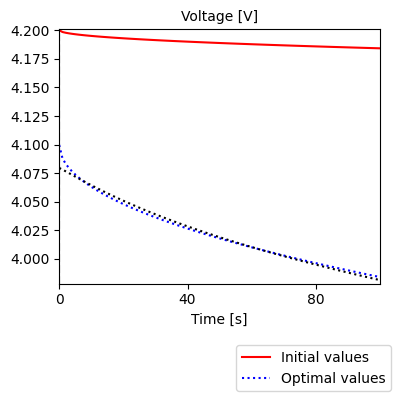

In [12]:
result.plot()